In [ ]:
!pip install torch==1.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.13.1+cpu which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.1+cpu which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.1+cpu which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 1.13.1+cpu which is incompatible.


In [ ]:
!pip install numpy gym matplotlib

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
gamma = 0.99

# pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = actor_func(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

env = gym.make("CartPole-v1")
reward_records = []
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.001)
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=0.001)
for i in range(1500):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    rewards = []
    s = env.reset()
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Train (optimize parameters)
    #

    # Optimize value loss (Critic)
    opt1.zero_grad()
    states = torch.tensor(states, dtype=torch.float).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    values = value_func(states)
    values = values.squeeze(dim=1)
    vf_loss = F.mse_loss(
        values,
        cum_rewards,
        reduction="none")
    vf_loss.sum().backward()
    opt1.step()

    # Optimize policy loss (Actor)
    with torch.no_grad():
        values = value_func(states)
    opt2.zero_grad()
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    advantages = cum_rewards - values
    logits = actor_func(states)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    pi_loss = -log_probs * advantages
    pi_loss.sum().backward()
    opt2.step()

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, sum(rewards)), end="\r")
    reward_records.append(sum(rewards))

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")
env.close()

Run episode1068 with rewards 500.0
Done


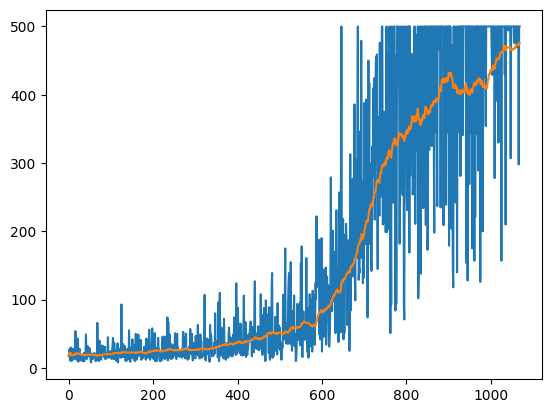

In [ ]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)